# Using Elbow Method to find the optimal number of clusters

Elbow method is applied to find optimal number of clusters for K-means clustering. 
Here is how K-means method is used with Python to divide a set into groups, or clusters:
https://pythonprogramminglanguage.com/kmeans-clustering-algorithm/

And here is Elbow method:
https://pythonprogramminglanguage.com/kmeans-elbow-method/

To utilize it we need a metric from K-means module to measure total sum of tightnesses for each cluster. Then we plot metric values for different number of clusters. We connect the dots for each metric value and choose the number for which we see the smallest angle above a corresponding point at our plot. 

The method is not dependable because it relies on visual angle estimations. I will start with showing how it fails for some cases. 

At first let us generate a data set with 10 clusters.

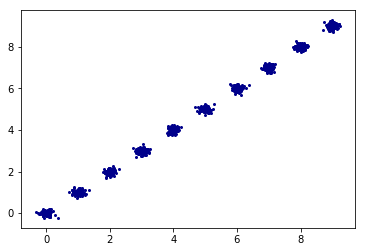

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

# number of clusters: real and assumed for testing.
true_n_cluster = 10

n_obs = 100

X = None

for i in range(true_n_cluster):
    x = np.random.normal(loc=i, size=n_obs, scale=0.1)
    y = np.random.normal(loc=i, size=n_obs, scale=0.1)
    data = np.column_stack([x, y])
    if X is None:
        X = data
    else:
        X = np.row_stack([X, data])

fig, ax = plt.subplots()

ax.plot(X[:, 0], X[:, 1], 'o', markersize=2, c='darkblue');

We got 10 distinct clusters. They are well suited for K-means method because they are tight and clearly separated. Now we can compute a metric called "within cluster sums of squares". We will do it for a range of assumed cluster numbers from 1 to 20.

## Computing within-cluster sum of squares measure (WCSS)
## for cluster numbers from 1 to 20

In [2]:
test_n_cluster = 20
within_cluster_sum_squares = np.zeros(test_n_cluster)

for i in range(test_n_cluster):
    n = i+1
    kmeans = KMeans(n_clusters = n, init = 'k-means++', max_iter=500, n_init=20, random_state = 0)
    kmeans.fit(X)
    within_cluster_sum_squares[i] = kmeans.inertia_
    
np.set_printoptions(suppress=True)
np.around(within_cluster_sum_squares, 2)

array([16508.65,  4025.72,  1817.05,  1016.49,   524.88,   415.72,
         314.53,   214.91,   116.74,    21.23,    20.29,    19.38,
          18.52,    17.85,    17.11,    16.07,    15.52,    14.78,
          14.14,    13.41])

We can observe that for first 10 steps the values decrease rapidly, but afterwards they level out and do not decrease as quickly anymore. So numerically Elbow method must pick up on this. Of course a picture would be more convenient than sifting numbers.

## Plots to show difficulties with Elbow method

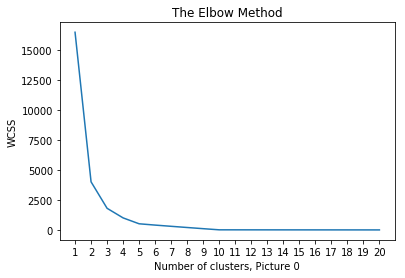

In [3]:
fig, ax = plt.subplots()

ax.plot(within_cluster_sum_squares)

xticks = np.arange(test_n_cluster)
xticklabels = xticks + 1
ax.set(xticks=xticks, xticklabels=xticklabels, title='The Elbow Method', 
       xlabel='Number of clusters, Picture 0', ylabel='WCSS');

Here visually detecting the best number of clusters is impossible. Currently only angles for numbers 2 and 3 look like good candidates, but we know that the best number of clusters here is 10. The reason for the mistake is that scaling along the vertical axis to fit the plot into our page distorted our visualization. We can change observed intervals and  look at different parts of the plot, thus discovering the phenomena. (You can find a video in the repository which shows how look of the graph changes when its horizontal axis is compressed.) Below first plot is restricted to cluster numbers from 1 to 12 and the second displays them from 7 to 20.


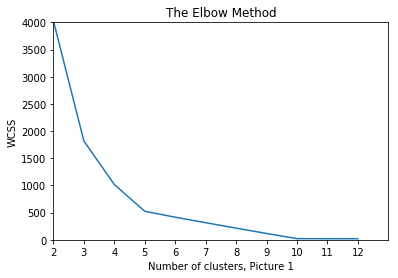

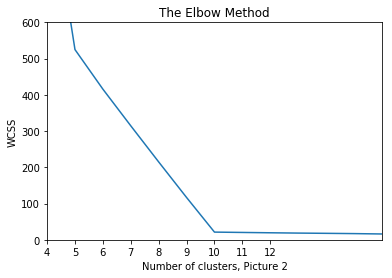

In [4]:
fig, ax = plt.subplots()
ax.plot(within_cluster_sum_squares[0:12])
ax.set_xlim(1, 12)
ax.set_ylim(0, 4000)

xticks = np.arange(1, 12)
xticklabels = xticks + 1
ax.set(xticks=xticks, xticklabels=xticklabels, title='The Elbow Method', 
       xlabel='Number of clusters, Picture 1', ylabel='WCSS');

fig, ax = plt.subplots()
ax.plot(within_cluster_sum_squares)
ax.set_xlim(3, 15)
ax.set_ylim(0, 600)

xticks = np.arange(3, 12)
xticklabels = xticks + 1
ax.set(xticks=xticks, xticklabels=xticklabels, title='The Elbow Method', 
       xlabel='Number of clusters, Picture 2', ylabel='WCSS');

As we see these are parts of the same plot and the only differences are changes of horizontal and vertical intervals, which affects how axes are scaled. A visual estimation of first picture yields the best number of clusters as 5, and in the second we see that 10 is more likely. Mind you that I went as far as 20 clusters because I knew that the best number is somewhere here, and that in the second picture scaling of its vertical axes differs with the first picture by a multiple of 0.15. 

Hence pictures are helpful only when we know where to look since scaling can distort our angles. But the clustering is supposed to detect the correct number of clusters, meaning that a priory we cannot know. 

There are ways in math to evaluate angle values without geometric plots.

Let us try to compute the angle cosines. In this case we only want angles with values between 0 and 180 degrees. for them the greatest cosine corresponds to the smallest angle. I've added -1 at the start for 1 cluster (no angle is here) and replaced all angles which are greater than 180 degrees with -1. The last condition visually looks on our plot like a point situated above a line connecting 2 closest points.

In [5]:
# Let us use a shorter variable name
wcss = within_cluster_sum_squares

cosines = -1 * np.ones(test_n_cluster)

for i in range(test_n_cluster-1):
   # check if the point is below a segment midpoint connecting its neighbors
   if (wcss[i] < (wcss[i+1]+wcss[i-1])/2 ):
       cosines[i]= (-1+(wcss[i-1]-wcss[i])*(wcss[i+1]-wcss[i]))/ \
       ((1+(wcss[i-1]-wcss[i])**2)*(1+ (wcss[i+1]-wcss[i])**2))**.5
np.around(cosines, 3)

array([-1.   , -1.   , -1.   , -1.   , -1.   , -1.   , -1.   , -1.   ,
       -1.   , -0.69 , -1.   , -1.   , -0.993, -1.   , -1.   , -0.956,
       -1.   , -0.998, -1.   , -1.   ])

If we check it out we can figure out that 10th number is the least value. Let us sort the cosine array and get indices of the smallest angles at the front.

In [6]:
print(np.flip(np.argsort(cosines))+1)

[10 16 13 18 12 11  5  3  4  6  2  9  7  8 20 19 14 15 17  1]


Clearly the computed cosines are not affected by plot scaling and they are better indication of the best number of clusters. 

**Remark.** Elbow Method works well only for distinctly separated tight clusters for which K-means procedure was created. When applied to clusterings of other types we may get variable results. When it happens we see repeated applications (with different random_state parameters) of the above method yielding different first "optimal" numbers.  It is an indication that the procedure does not perform consistently for such data. In this case we may 1) make a conscious choice about a preferable number of clusters, 2) scale data or apply diverse weights to columns, 3) try other clustering methods.

Here is a function for this. 

In [7]:
def ElbowMethod(array, top_cluster_number, remark=True, init = 'k-means++', max_iter = 300, n_init = 10, random_state = None):
    import numpy as np
    from sklearn.cluster import KMeans
    wcss = np.zeros(top_cluster_number)
    
    for i in range(top_cluster_number):
        n = i+1
        kmeans = KMeans(n_clusters = n, init=init, max_iter=max_iter, n_init=n_init, random_state=random_state)
        kmeans.fit(X)
        wcss[i] = kmeans.inertia_
    
    cosines = -1 * np.ones(top_cluster_number)
    
    for i in range(top_cluster_number-1):
    # check if the point is below a segment midpoint connecting its neighbors
        if (wcss[i] < (wcss[i+1]+wcss[i-1])/2 ):
            cosines[i]= (-1+(wcss[i-1]-wcss[i])*(wcss[i+1]-wcss[i]))/ \
            ((1+(wcss[i-1]-wcss[i])**2)*(1+ (wcss[i+1]-wcss[i])**2))**.5
    
    if remark:
        print("""Remark: If repeated applications(with different random_state parameters) yield different 
        values for the optimal number then K-means method does not work well on the array.""")
    
        return (np.flip(np.argsort(cosines))+1)

ElbowMethod(X, 20, max_iter=500, n_init=20)


Remark: If repeated applications(with different random_state parameters) yield different 
        values for the optimal number then K-means method does not work well on the array.


array([10, 18, 12, 16, 15,  5,  3,  4,  6, 11,  2,  9,  7,  8, 20, 19, 13,
       14, 17,  1])